### Setup and library imports
- **Where**: This cell initializes the environment at the top of the notebook.
- **What**: Imports core Python libraries for data handling, visualization, clustering, and hierarchical analysis.
- **Why**: These libraries provide the tools needed for loading data, preprocessing, running clustering algorithms, and visualizing results.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Load dataset
- **Where**: Data ingestion section.
- **What**: Reads `cricket.csv` using the correct text encoding and previews the top rows.
- **Why**: Loads raw data into a DataFrame to enable subsequent exploration and modeling.


In [23]:
df = pd.read_csv("cricket.csv",encoding="ISO-8859-1")
df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


### Inspect schema and data types
- **Where**: Early EDA (exploratory data analysis).
- **What**: Prints DataFrame info to view row counts, column types, and memory usage.
- **Why**: Verifies there are no missing values and confirms which columns are numerical vs. categorical for preprocessing.


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     object 
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.2+ KB


### List columns
- **Where**: Still in EDA.
- **What**: Displays the column names of the dataset.
- **Why**: Helps select appropriate features for scaling and clustering.


In [25]:
df.columns

Index(['Player', 'Span', 'Mat', 'Inns', 'NO', 'Runs', 'HS', 'Ave', 'BF', 'SR',
       '100', '50', '0'],
      dtype='object')

### Standardize numerical features
- **Where**: Preprocessing step before modeling.
- **What**: Uses `StandardScaler` to standardize selected numerical columns and inspects the transformed array shape.
- **Why**: Puts features on a comparable scale so distance-based clustering (K-Means, hierarchical) behaves properly.


In [26]:
scaler = StandardScaler()

df_fitted = scaler.fit_transform(df[['Mat', 'Inns', 'NO', 'Runs', 'Ave', 'BF', 'SR', '100', '50', '0']])
df_fitted.shape

(79, 10)

### Wrap standardized array into DataFrame
- **Where**: End of preprocessing.
- **What**: Converts the scaled NumPy array into a pandas DataFrame for easier manipulation.
- **Why**: Keeps feature values aligned by row and simplifies downstream analysis and plotting.


In [27]:
df_2 = pd.DataFrame(df_fitted)

### Define Hopkins statistic function
- **Where**: Clustering tendency assessment.
- **What**: Implements the Hopkins statistic to measure how clusterable the dataset is.
- **Why**: Ensures the data has a meaningful clustering structure before applying clustering algorithms.


In [28]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

### Compute Hopkins statistic (repeated trials)
- **Where**: Immediately after defining `hopkins`.
- **What**: Runs the Hopkins statistic 50 times on the scaled data and averages the result.
- **Why**: Reduces variance in the estimate; a value ~0.7–0.99 indicates strong clustering tendency.


In [29]:
hopkin_result = []

for h in range(50):
    hopkin_result.append(hopkins(df_2))
print(sum(hopkin_result)/50)

#If the value is between {0.01, ...,0.3}, the data is regularly spaced.

#If the value is around 0.5, it is random.

#If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

0.7568824346447154


### Fit K-Means clustering
- **Where**: Modeling phase.
- **What**: Initializes K-Means with `n_clusters=4` and fits it on the standardized features.
- **Why**: Segments players into groups based on performance attributes for downstream analysis.


In [30]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(df_2)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,50
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


### Inspect cluster assignments
- **Where**: Post-model fit.
- **What**: Displays the cluster labels assigned by the K-Means model.
- **Why**: Provides a quick look at how many clusters and which samples belong to each group.


In [31]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1,
       1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 1, 0, 0, 3, 0, 3,
       3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int32)

### Attach cluster IDs to original DataFrame
- **Where**: Enrichment of original data.
- **What**: Adds a `Cluster_ID` column to `df` from the model’s labels.
- **Why**: Enables analysis of players and their raw stats alongside their assigned cluster.


In [32]:
df["Cluster_ID"] = kmeans.labels_

### Preview enriched data
- **Where**: After labeling clusters.
- **What**: Shows the first few rows of `df` with the new `Cluster_ID` column.
- **Why**: Quick sanity check that labels were added correctly and data still looks consistent.


In [33]:
df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Cluster_ID
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,2
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,2
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,2
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34,2
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,2


### Query specific players
- **Where**: Exploratory drill-down.
- **What**: Defines a small list of player names and filters `df` for players matching "Yuv".
- **Why**: Demonstrates how to inspect particular players and relate them to their cluster assignments.


In [34]:
pl = ["Virat Kohli", "CH Gayle","SR Tendulkar","ST Jayasuriya","Yuvraj Singh"]
df[df.Player.str.contains("Yuv", case=False,na= False)]

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Cluster_ID
20,Yuvraj Singh (Asia/INDIA),2000-2017,304,278,40,8701,150,36.55,9924,87.67,14,52,18,3


### Inspect scaled features (head)
- **Where**: Post-scaling verification.
- **What**: Displays the first rows of the standardized feature DataFrame.
- **Why**: Confirms scaling produced sensible transformed values and preserved row order.


In [35]:
df_2.head()

,0,1,2,3,4,5,6,7,8,9
0,2.955282,3.169333,0.764963,4.262328,1.072294,3.681214,0.703152,4.656726,3.050057,1.145837
1,2.155179,2.138915,0.764963,2.609117,0.587725,2.635385,-0.044139,1.671888,2.865418,0.296671
2,1.761908,1.924245,0.625397,2.400099,0.596226,2.319651,0.110997,2.293729,2.188406,1.145837
3,2.711183,2.897417,-0.840046,2.292041,-1.047909,1.588295,1.207091,2.044992,1.326755,3.523501
4,2.751866,2.682747,0.625397,1.984430,-0.876185,1.996354,-0.034000,0.925678,1.880674,2.504502


### Hierarchical clustering visualization (dendrogram)
- **Where**: Visualization section.
- **What**: Selects a subset of scaled features (average and strike rate), computes linkage with complete method, and plots a dendrogram.
- **Why**: Offers an alternative view of player similarity and potential grouping structure beyond K-Means.


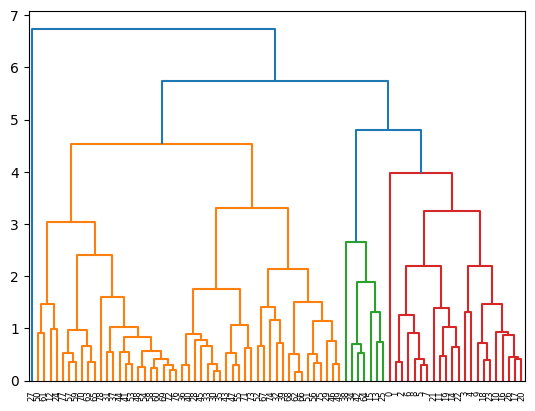

In [36]:
df_f = df_2.loc[:,4:6] #SR,AVE
mergings = linkage(df_f,method="complete",metric="euclidean")
dendrogram(mergings)
plt.savefig('../assets/dendrogram.png', dpi=150)
plt.show()

### Cluster profile summary (means)
- **What**: Aggregate key stats by `Cluster_ID` to understand each segment’s profile.
- **Why**: Turns raw labels into interpretable cluster personas.


In [37]:
summary_cols = ['Runs','Ave','SR','100','50','0','Mat','Inns','NO','BF']
cluster_summary = df.groupby('Cluster_ID')[summary_cols].mean().round(2)
cluster_counts = df['Cluster_ID'].value_counts().sort_index()
cluster_summary, cluster_counts


(                Runs    Ave     SR    100     50      0     Mat    Inns  \
 Cluster_ID                                                                
 0            5782.21  39.02  77.18   8.44  36.03   9.76  183.38  173.32   
 1            8844.85  44.43  78.19  14.23  55.46  10.15  264.62  246.54   
 2           13112.67  39.85  78.63  23.56  82.22  20.33  388.44  370.00   
 3            7488.74  33.94  83.30   9.96  42.74  17.39  269.13  251.52   
 
                NO        BF  
 Cluster_ID                   
 0           23.12   7570.03  
 1           42.85  11440.77  
 2           38.56  16622.56  
 3           29.70   9102.52  ,
 Cluster_ID
 0    34
 1    13
 2     9
 3    23
 Name: count, dtype: int64)

### Visualize clusters in feature space
- **What**: Scatter plot of `Ave` vs `SR` colored by `Cluster_ID`.
- **Why**: Intuitive view of player types (e.g., consistent vs. explosive).


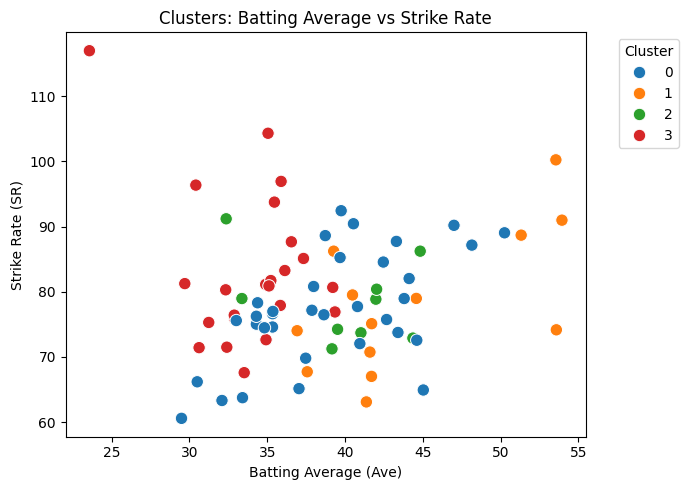

In [38]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Ave', y='SR', hue='Cluster_ID', palette='tab10', s=80)
plt.title('Clusters: Batting Average vs Strike Rate')
plt.xlabel('Batting Average (Ave)')
plt.ylabel('Strike Rate (SR)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../assets/scatter_ave_sr.png', dpi=150)
plt.show()


### Evaluate cluster quality (silhouette score)
- **What**: Compute silhouette score on standardized features with current labels.
- **Why**: Quantifies separation/compactness; higher is better (~0.2–0.6 is common in real data).


In [39]:
sil_score = silhouette_score(df_2, kmeans.labels_)
print('Silhouette score:', round(sil_score, 3))


Silhouette score: 0.226


### Export results for use elsewhere
- **What**: Save player names with their `Cluster_ID` to CSV.
- **Why**: Share or use cluster assignments in other tools.


In [40]:
df[['Player','Cluster_ID']].to_csv('player_clusters.csv', index=False)
'player_clusters.csv written'


'player_clusters.csv written'